## Project 4: Exploring the UK's milk imports and exports

by Tony Hirst and Michel Wermelinger, 19 November 2015 and 28 March 2016 with ammendments by Chris Pyves 17th November 2016.

This is the project notebook for Week 4 of The Open University's [_Learn to Code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2015:

- How much does the UK export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [321]:
# Now Repeat the whole analysis for January–May 2014 and compare the results:

In [322]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2015 [note datafile says Jan_Jul_2015]
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [323]:
#Type of Product: goods
#Frequency: monthly
#Periods: January to May of 2015
#Reporter: United Kingdom
#Partners: all
#Flows: imports and exports
#HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)
# http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201501%2C201502%2C201503%2C201504%2C201505&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv
#downloaded comtrade(12).csv

In [324]:
#Type of Product: goods
#Frequency: monthly
#Periods: January to May of 2014[ Note: systems limit: can only select 5 items]
#Reporter: United Kingdom
#Partners: all
#Flows: imports and exports
#HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)
# http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201401%2C201402%2C201403%2C201404%2C201405&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv
#downloaded comtrade(13).csv

In [325]:
# Now Repeat the whole analysis for January–May 2014 and compare the results:
# there seem to be two ways of approaching this problem
# 1. Repeat what has already been done but with a new datafile, or
# 2. Add the previous year data to the file and work through the questions using all the techniques and methods that we have learnt

In [326]:
LOCATION2 = 'comtrade_milk_uk_jan_jul_15.csv'# OK
LOCATION1 = 'comtrade_milk_uk_jan_may_14.csv'# OK

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [327]:
# LOCATION2 = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'
# LOCATION1 = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201401%2C201402%2C201403%2C201404%2C201405&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [328]:
milk1 = read_csv(LOCATION1, dtype={'Commodity Code':str})# 2014
milk1.tail(2)
#type(milk1)# pandas.core.frame.DataFrame
#milk1.describe# [606 rows x 35 columns]

Classification  Year  Period Period Desc.  Aggregate Level  Is Leaf Code  \
604             HS  2014  201405     May 2014                4             0   
605             HS  2014  201405     May 2014                4             0   

     Trade Flow Code Trade Flow  Reporter Code        Reporter  ...   Qty  \
604                2    Exports            826  United Kingdom  ...   NaN   
605                2    Exports            826  United Kingdom  ...   NaN   

     Alt Qty Unit Code Alt Qty Unit  Alt Qty  Netweight (kg)  \
604                NaN          NaN      NaN           18480   
605                NaN          NaN      NaN           50000   

     Gross weight (kg)  Trade Value (US$)  CIF Trade Value (US$)  \
604                NaN              30162                    NaN   
605                NaN             313417                    NaN   

     FOB Trade Value (US$)  Flag  
604                    NaN     0  
605                    NaN     0  

[2 rows x 35 columns]

In [329]:
milk2 = read_csv(LOCATION2, dtype={'Commodity Code':str})# 2015
milk2.tail(2)

Classification  Year  Period Period Desc.  Aggregate Level  Is Leaf Code  \
635             HS  2015  201505     May 2015                4             0   
636             HS  2015  201505     May 2015                4             0   

     Trade Flow Code Trade Flow  Reporter Code        Reporter  ...   Qty  \
635                2    Exports            826  United Kingdom  ...   NaN   
636                2    Exports            826  United Kingdom  ...   NaN   

     Alt Qty Unit Code Alt Qty Unit  Alt Qty  Netweight (kg)  \
635                NaN          NaN      NaN            2213   
636                NaN          NaN      NaN            1588   

     Gross weight (kg)  Trade Value (US$)  CIF Trade Value (US$)  \
635                NaN              37883                    NaN   
636                NaN               5676                    NaN   

     FOB Trade Value (US$)  Flag  
635                    NaN     0  
636                    NaN     0  

[2 rows x 35 columns]

The data in the two files above only covers the first five months of 2014 & 2015. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [330]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

In [331]:
COMMODITY = 'Milk and cream'
milk1[COMMODITY] = milk1['Commodity Code'].apply(milkType)
YEAR = 'Year'
PERIOD = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [YEAR, PERIOD, PARTNER, FLOW, COMMODITY, VALUE]
milk1 = milk1[headings]
milk1.tail()

Year  Period                  Partner Trade Flow Milk and cream  \
601  2014  201405     United Arab Emirates    Exports      processed   
602  2014  201405                   Uganda    Exports      processed   
603  2014  201405                    Egypt    Exports      processed   
604  2014  201405  United Rep. of Tanzania    Exports      processed   
605  2014  201405             Burkina Faso    Exports      processed   

     Trade Value (US$)  
601             243150  
602             415292  
603             941909  
604              30162  
605             313417

In [332]:
COMMODITY = 'Milk and cream'
milk2[COMMODITY] = milk2['Commodity Code'].apply(milkType)
YEAR = 'Year'
PERIOD = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [YEAR, PERIOD, PARTNER, FLOW, COMMODITY, VALUE]
milk2 = milk2[headings]
milk2.tail()

Year  Period                  Partner Trade Flow Milk and cream  \
632  2015  201505                   Sweden    Exports      processed   
633  2015  201505              Switzerland    Exports      processed   
634  2015  201505     United Arab Emirates    Exports      processed   
635  2015  201505                   Turkey    Exports      processed   
636  2015  201505  United Rep. of Tanzania    Exports      processed   

     Trade Value (US$)  
632                569  
633              16713  
634             338823  
635              37883  
636               5676

In [333]:
# merge(left=frame1, right=frame2, on=columnName, how=string) returns a new dataframe, 
# obtained by joining the two frames on the columns with the given common name. 
# The how argument can be one of ‘left’, ‘right’, ‘inner’ and ‘outer’.

In [334]:
# Join the two data files using append
milk = milk1.append(milk2)
# reset the index 605 + 1 + 636 + 1 = 1242 rows (0 - 1242)
# frame = frame.reset_index(drop=True) returns a new dataframe in which rows are labelled from 0 onwards.
milk = milk.reset_index(drop=True)
milk.tail()
#milk.describe # [1243 rows x 6 columns]

Year  Period                  Partner Trade Flow Milk and cream  \
1238  2015  201505                   Sweden    Exports      processed   
1239  2015  201505              Switzerland    Exports      processed   
1240  2015  201505     United Arab Emirates    Exports      processed   
1241  2015  201505                   Turkey    Exports      processed   
1242  2015  201505  United Rep. of Tanzania    Exports      processed   

      Trade Value (US$)  
1238                569  
1239              16713  
1240             338823  
1241              37883  
1242               5676

The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [335]:
milk = milk[milk[PARTNER] != 'World']
milk.tail()#
#milk[350:400]

Year  Period                  Partner Trade Flow Milk and cream  \
1238  2015  201505                   Sweden    Exports      processed   
1239  2015  201505              Switzerland    Exports      processed   
1240  2015  201505     United Arab Emirates    Exports      processed   
1241  2015  201505                   Turkey    Exports      processed   
1242  2015  201505  United Rep. of Tanzania    Exports      processed   

      Trade Value (US$)  
1238                569  
1239              16713  
1240             338823  
1241              37883  
1242               5676

In [336]:
# Check your data:
result = pivot_table(milk,
                     index=[YEAR],
                     columns= PERIOD,
                     values=VALUE,
                     aggfunc=sum)
result
# This suggest you may need to create a MONTH column - which when combined with Year will give you the granularity you require
# see next cell:

Period     201401     201402     201403     201404     201405    201501  \
Year                                                                      
2014    139512730  111789783  131100878  139406385  144276259       NaN   
2015          NaN        NaN        NaN        NaN        NaN  86330673   

Period    201502    201503    201504    201505  
Year                                            
2014         NaN       NaN       NaN       NaN  
2015    76215898  84114502  85389026  89463540

In [337]:
MONTH = 'Month'
milk[MONTH]=milk[PERIOD].astype(str).str[5:].astype('int64')# removes year from Period and puts month value in MONTH column
#milk[MONTH]# operation successful
#milk.dtypes

In [338]:
# Now check the data (using MONTH):
result = pivot_table(milk,
                     index=[MONTH],
                     columns= YEAR,
                     values=VALUE,
                     aggfunc=sum)
result

Year        2014      2015
Month                     
1      139512730  86330673
2      111789783  76215898
3      131100878  84114502
4      139406385  85389026
5      144276259  89463540

## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [339]:
# Original answer:
# This is a neat way to get the two totals - adding another YEAR of data just requires adding YEAR to groupby
grouped = milk.groupby([YEAR,FLOW])[VALUE]# puts it all in one statement
# grouped.groups.keys()# dict_keys([(2014, 'Imports'), (2015, 'Imports'), (2015, 'Exports'), (2014, 'Exports')])
# grouped.get_group(groupName)
print ('in 2014 the trade surplus was: ',(grouped.get_group((2014, 'Exports')).sum())-(grouped.get_group((2014, 'Imports')).sum()))
print ('in 2015 the trade surplus was: ',(grouped.get_group((2015, 'Exports')).sum())-(grouped.get_group((2015, 'Imports')).sum()))

in 2014 the trade surplus was:  209527379
in 2015 the trade surplus was:  108545683


In [340]:
result = pivot_table(milk,
                     index=[MONTH,COMMODITY],
                     columns= [YEAR , FLOW],
                     values=VALUE,
                     aggfunc=sum)
result
#note these totals are all positive - may have to create InFlows & OutFlows to report Net Trade Flow (see cell below)

Year                      2014                2015          
Trade Flow             Exports   Imports   Exports   Imports
Month Milk and cream                                        
1     processed       40215103  30423330  26195709  19770570
      unprocessed     46923551  21950746  26259790  14104604
2     processed       32298379  20614513  21025054  17405593
      unprocessed     40191337  18685554  25359029  12426222
3     processed       42987355  26335257  26293698  19060366
      unprocessed     43794069  17984197  26028318  12732120
4     processed       52900517  24770338  29029756  15331783
      unprocessed     42295261  19440269  25981444  15046043
5     processed       55987927  26409462  29415739  16511555
      unprocessed     40213208  21665662  29441124  14095122

In [341]:
NET='Netflow'
values= milk['Trade Value (US$)']# set up values
milk[NET] = values.where(milk[FLOW] == 'Exports', other=-values)#apply condition
#milk.head()
result = pivot_table(milk,
                     index=[MONTH,COMMODITY],
                     columns= [YEAR, FLOW],
                     values=NET,
                     aggfunc=sum)
print('2014 Net Flows',result[2014].sum().sum())
print('2015 Net Flows',result[2015].sum().sum())
result#

2014 Net Flows 209527379
2015 Net Flows 108545683


Year                      2014                2015          
Trade Flow             Exports   Imports   Exports   Imports
Month Milk and cream                                        
1     processed       40215103 -30423330  26195709 -19770570
      unprocessed     46923551 -21950746  26259790 -14104604
2     processed       32298379 -20614513  21025054 -17405593
      unprocessed     40191337 -18685554  25359029 -12426222
3     processed       42987355 -26335257  26293698 -19060366
      unprocessed     43794069 -17984197  26028318 -12732120
4     processed       52900517 -24770338  29029756 -15331783
      unprocessed     42295261 -19440269  25981444 -15046043
5     processed       55987927 -26409462  29415739 -16511555
      unprocessed     40213208 -21665662  29441124 -14095122

These figures indicate that in the first five months Jan - May the UK trade surplus has declined by 100m dollars from 209m dollars in 2014 to 109m dollars in 2015.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [342]:
# The following cells are various attempts at reworking the data with different coding approaches to achieve the desired result
# First pass - note: table now contains two years of data instead of one - results will by combined (see cell below)
# make your selection by FLOW then use groupby
imports = milk[milk[FLOW] == 'Imports']# with additional year data an additional filter is required (see cell below)
grouped = imports.groupby([PARTNER])
#print('The UK imports from', len(grouped), 'countries.')
#print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort(inplace=False,ascending=False)# this now includes both years!!!!!!
#totalImports.head()

In [343]:
# second pass using same approach as first to return results by year
imports2014 = milk[((milk[FLOW] == 'Imports') & (milk[YEAR] == 2014))]# simply add a year to your filter
grouped = imports2014.groupby([PARTNER])
print('In 2014 the UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort(inplace=False,ascending=False)
totalImports.head()

In 2014 the UK imports from 23 countries.
The 5 biggest exporters to the UK are:


Partner
Ireland        75342679
France         43094286
Germany        29234902
Belgium        26762776
Netherlands    25742755
Name: Trade Value (US$), dtype: int64

In [344]:
# How to use groupby as a filter (without resorting to the filter function)
# Problem: to return total number of countries imported/exported with during a given year
# grouped = milk.groupby(['Year','Trade Flow'])# extracts key components 'Year' & 'Flow' (does not incluse country)
# next line strips out a unique list of countries traded with and returns total count:
# len(grouped.get_group((2014,'Imports'))['Partner'].unique())# how identify which countries you imported/exported with in a given year
# consolidated into one line
# len(milk.groupby(['Year','Trade Flow']).get_group((2014,'Imports'))['Partner'].unique())

In [345]:
# second pass using pivot table to return both year results
# make your selection (at detail level) then summarise:
# How to return total countries you imported/exported with in a given year using groupby without filter
print('In 2014 the UK imported from',len(milk.groupby(['Year','Trade Flow']).get_group((2014,'Imports'))['Partner'].unique()),'countries')
print('In 2015 the UK imported from',len(milk.groupby(['Year','Trade Flow']).get_group((2015,'Imports'))['Partner'].unique()),'countries')
print('The following table shows the top 5 importers for 2015')
result = pivot_table(milk,
                     index=[PARTNER],
                     columns= [YEAR , FLOW],
                     values=VALUE,
                     aggfunc=sum)
result.dropna().sort((2015,'Imports'),ascending=False).head(5)# sorts by latest year Imports descending order
#note the results in original cell (first pass) will now report results for two years

In 2014 the UK imported from 23 countries
In 2015 the UK imported from 21 countries
The following table shows the top 5 importers for 2015


Year              2014                 2015          
Trade Flow     Exports   Imports    Exports   Imports
Partner                                              
Ireland      200713266  75342679  128155891  46263897
France        19856738  43094286    9381762  28314091
Germany       17966838  29234902   10828464  21899123
Netherlands   38625707  25742755   18018603  17658912
Belgium       20506014  26762776    7209121  14325697

The UK import values by country can be plotted as a bar chart, making differences between countries & year easier to see.

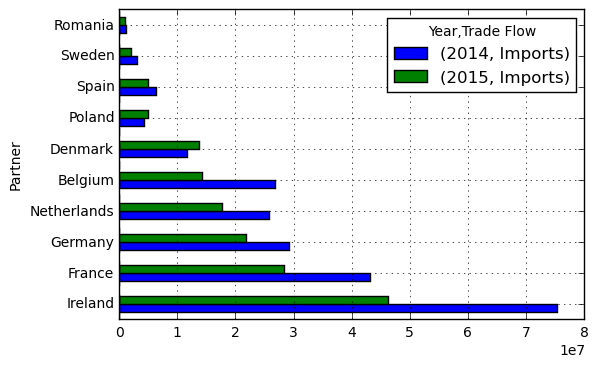

In [346]:
#totalImports.head(10).plot(kind='barh')# worked with original data
# How to plot bar chart for both years Imports?
result.dropna().sort((2015,'Imports'),ascending=False)[[(2014,'Imports'),(2015,'Imports')]].head(10).plot(kind='barh')

From these results it can be seen that in 2015 the UK reduced imports from its top 5 suppliers (in the first five months compared to 2014).

In [347]:
# Additional question: Who are regular exporters to the UK (i.e. more than 10 months of sales)
def sellsEveryMonth(g):
    return (len(g) >= 10)
importer = milk[(milk[FLOW]=='Imports')]# simple but powerful comand to return imports only
regular = importer.groupby([YEAR,PARTNER]).filter(sellsEveryMonth)
countries = pivot_table(regular, 
                        index=[PARTNER], 
                        columns=[YEAR,FLOW], 
                        values=VALUE, 
                        aggfunc=[len,sum])
countries.sort(('sum',2015,'Imports'),ascending=False)# how to specify a pivot table col to sortby
# note: can put .dropna() after countries to exclude places like Denmark but that would be wrong.

len               sum          
Year           2014    2015      2014      2015
Trade Flow  Imports Imports   Imports   Imports
Partner                                        
Ireland          10      10  75342679  46263897
France           10      10  43094286  28314091
Germany          10      10  29234902  21899123
Netherlands      10      10  25742755  17658912
Belgium          10      10  26762776  14325697
Denmark         NaN      10       NaN  13681759
Poland           10      10   4336432   4933917
Sweden           10      10   3107260   1962413
Italy            10      10    542209    321635
Lithuania        10      10    186038    318407
Portugal        NaN      10       NaN    308654

Now lets look at who the UK exports to:

In [348]:
# Note original code - worked for 2015 but now you have added 2014 it will report total for both years
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')

grouped[VALUE].aggregate(sum).order(ascending=False).head()

The UK exports to 120 countries.


Partner
Ireland        328869157
Algeria         64469244
Netherlands     56644310
France          29238500
Germany         28795302
Name: Trade Value (US$), dtype: int64

In [349]:
# second pass using pivot table to return both year results
# make your selection (at detail level) then summarise:
# How to return total countries you imported/exported with in a given year using groupby without filter
exports = milk[milk[FLOW] == 'Exports']
print('Len(exports. In 2014 the UK exported to',len(exports.groupby(['Year','Trade Flow']).get_group((2014,'Exports'))['Partner'].unique()),'countries')
print('In 2015 the UK exported to',len(exports.groupby(['Year','Trade Flow']).get_group((2015,'Exports'))['Partner'].unique()),'countries')
print('The 5 biggest importers from the UK are:')
result = pivot_table(exports,
                     index=[PARTNER],
                     columns= [YEAR , FLOW],
                     values=VALUE,
                     aggfunc=sum)
result.dropna().sort((2015,'Exports'),ascending=False).head(5)
#note the results in original cell (first pss) will now report results for two years

Len(exports. In 2014 the UK exported to 107 countries
In 2015 the UK exported to 107 countries
The 5 biggest importers from the UK are:


Year                       2014       2015
Trade Flow              Exports    Exports
Partner                                   
Ireland               200713266  128155891
Netherlands            38625707   18018603
China                   7700931   14111163
Germany                17966838   10828464
China, Hong Kong SAR    8637173    9482458

In [350]:
# Where could the export market be further developed, i.e. which countries import the least? Do the figures look realistic?
countries = pivot_table(exports, 
                        index=[PARTNER], 
                        columns=[YEAR,FLOW], 
                        values=VALUE, 
                        aggfunc=sum)
countries.sort((2015,'Exports')).head(10)
# The figures are too low to start with - may heve to start higer up >greater than
# Poor countries that have better cattle & grazing than we do. Need to study each market for niche opportunities
# What are they buying when & why?

Year          2014    2015
Trade Flow Exports Exports
Partner                   
Croatia         17       5
Romania       5829      36
Slovakia       314      65
Estonia        881     102
Bulgaria       198     216
Luxembourg   17006     448
Latvia          41     567
Lithuania     1216    1172
Ethiopia       NaN    2188
Czech Rep.   78055    2590

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [351]:
# Original code - see improved code in next cell
#def buysEveryMonth(group):
#    return len(group) == 10

#grouped = exports.groupby([PARTNER])
#regular = grouped.filter(buysEveryMonth)
#regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]

In [352]:
# which countries buy milk from the UK every month?
# a regular customer = imports both commodities every month: Partner Year 'Exports' 'Both Commodoities' = 10
def bothImpExp(g): 
    return (len(g)==10) & (g[VALUE].min() > 0)# set at 20 cos you have 5 months of data for each year x 2 years
# Partner year commodity flow =5 (combine flow = 10 = both imports & exports)
exports = milk[milk[FLOW] == 'Exports']
table = exports.groupby([YEAR,PARTNER]).filter(bothImpExp)# 
PT = pivot_table(table, 
                index = [PARTNER], 
                columns = [YEAR, FLOW], 
                values = VALUE,
#                margins = True,# True (default) or False seems to make no difference
                aggfunc = [len,sum])
PT.dropna() # 
# Whilst you might be willing to drop a contry that has a NaN in latest year does the same apply for a new customer who had NaN in prior year?
# see also calculation problems encountered as a result of using dropna below - does not return the correct resultant table data

len                sum           
Year                    2014    2015       2014       2015
Trade Flow           Exports Exports    Exports    Exports
Partner                                                   
Belgium                   10      10   20506014    7209121
China                     10      10    7700931   14111163
China, Hong Kong SAR      10      10    8637173    9482458
Cyprus                    10      10     129766     101579
Denmark                   10      10     331697     335068
France                    10      10   19856738    9381762
Germany                   10      10   17966838   10828464
Hungary                   10      10      96600      71378
Ireland                   10      10  200713266  128155891
Italy                     10      10      78354     173689
Malta                     10      10     159830     129516
Netherlands               10      10   38625707   18018603
Poland                    10      10     409739     106659
Portugal                  10      10      25916      25855
Spain                     10      10    1212545    1229172
Sweden                    10      10      45396      34972

In [353]:
#regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]
PT[('sum',2014,'Exports')].sum() / milk.groupby([YEAR,FLOW]).get_group((2014,'Exports'))[VALUE].sum(VALUE)# 

0.72457354108099581

In [354]:
#regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]
PT[('sum',2015,'Exports')].sum() / milk.groupby([YEAR,FLOW]).get_group((2015,'Exports'))[VALUE].sum(VALUE)# 

0.75835263963153166

Whilst in 2014 these regular customers represented 73% of total UK exports in 2015 it increased to 75%.

In [355]:
# note problem with dropna series total reports all in group.
PT[('sum',2014,'Exports')]

Partner
Austria                      5430
Belgium                  20506014
China                     7700931
China, Hong Kong SAR      8637173
Cyprus                     129766
Denmark                    331697
Finland                    721216
France                   19856738
Germany                  17966838
Hungary                     96600
Ireland                 200713266
Italy                       78354
Malta                      159830
Netherlands              38625707
Poland                     409739
Portugal                    25916
Spain                     1212545
Sweden                      45396
United Arab Emirates          NaN
Name: (sum, 2014, Exports), dtype: float64

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [356]:
# Which countries does the UK both import from and export to?',
# This whole task can be done so easily with pivot table = create NET column
# NET='Netflow'
# values= milk['Trade Value (US$)']# set up values
# milk[NET] = values.where(milk[FLOW] == 'Exports', other=-values)#apply correect sign to net column Exports=+ Imports=-
# sum is calculated by adding margins-True
# filter by year
table = milk[milk[YEAR] == 2014]# Need to select year
result = pivot_table(table,index=[PARTNER],columns=[YEAR,FLOW],values=[NET],margins=True,aggfunc=[sum]).dropna()
result

sum                      
                            Netflow                      
Year                           2014                   All
Trade Flow                  Exports    Imports           
Partner                                                  
Belgium                    20506014  -26762776   -6256762
Czech Rep.                    78055    -358822    -280767
Denmark                      331697  -11743192  -11411495
Finland                      721216        -12     721204
France                     19856738  -43094286  -23237548
Germany                    17966838  -29234902  -11268064
Greece                        14087         -7      14080
Hungary                       96600       -346      96254
Ireland                   200713266  -75342679  125370587
Italy                         78354    -542209    -463855
Latvia                           41       -567       -526
Lithuania                      1216    -186038    -184822
Luxembourg                    17006     -23724      -6718
Netherlands                38625707  -25742755   12882952
Poland                       409739   -4336432   -3926693
Portugal                      25916     -51332     -25416
Romania                        5829   -1228494   -1222665
Slovakia                        314     -90696     -90382
Spain                       1212545   -6406647   -5194102
Sweden                        45396   -3107260   -3061864
United Arab Emirates        1573610     -15629    1557981
United States of America     523017      -6790     516227
All                       437806707 -228279328  209527379

In [357]:
# What is the total amount of exports to and imports from the bi-lateral trade countries? 
#[Hint: pivot tables can have ‘marginal’ values.]
# Series of pivot table has colum total 'All' - need to access this result
count=len(result)
print('Total Net Trade for UK Milk Products:',result[('sum', 'Netflow', 'All')][count-1])# correct result is 209527379.0

Total Net Trade for UK Milk Products: 209527379.0


In [358]:
# How to get Net Trade result - series
# What is the total amount of exports to and imports from the bi-lateral trade countries? [Hint: pivot tables can have ‘marginal’ values.]
# just report sum 2,099,527,379 
#result[('sum','Netflow','All')]#.sum()

In [359]:
#'Which countries does the UK both import from and export to?'
# What is the total amount of exports to and imports from the bi-lateral trade countries? [Hint: pivot tables can have ‘marginal’ values.]
# This whole task can be done so easily with pivot table - sum is calulated by adding margins-True
#
countries = pivot_table(milk, index=[PARTNER], columns=[YEAR,FLOW], 
                        values=VALUE, dropna= True, margins=True, aggfunc=sum,)
countries# returns table of imports & exports by year by country total: 1087599674
#How to sort the list using 'All' as the criteria
countries.sort('All',ascending=False).dropna().head(10)

Year              2014                  2015                    All
Trade Flow     Exports    Imports    Exports    Imports            
Partner                                                            
All          437806707  228279328  265029661  156483978  1087599674
Ireland      200713266   75342679  128155891   46263897   450475733
France        19856738   43094286    9381762   28314091   100646877
Netherlands   38625707   25742755   18018603   17658912   100045977
Germany       17966838   29234902   10828464   21899123    79929327
Belgium       20506014   26762776    7209121   14325697    68803608
Denmark         331697   11743192     335068   13681759    26091716
Spain          1212545    6406647    1229172    4910615    13758979
Poland          409739    4336432     106659    4933917     9786747
Sweden           45396    3107260      34972    1962413     5150041

In [360]:
# 
NET='Netflow'
values= milk['Trade Value (US$)']# set up values
milk[NET] = values.where(milk[FLOW] == 'Exports', other=-values)#apply condition
#milk.head()
result = pivot_table(milk,
                     index=[MONTH,COMMODITY],
                     columns= [YEAR, FLOW],
                     values=NET,
                     #margins=True,# including this creates problems when summing values
                     aggfunc=sum)
print('2014 Net Flows',result[2014].sum().sum())
print('2015 Net Flows',result[2015].sum().sum())
result#

2014 Net Flows 209527379
2015 Net Flows 108545683


Year                      2014                2015          
Trade Flow             Exports   Imports   Exports   Imports
Month Milk and cream                                        
1     processed       40215103 -30423330  26195709 -19770570
      unprocessed     46923551 -21950746  26259790 -14104604
2     processed       32298379 -20614513  21025054 -17405593
      unprocessed     40191337 -18685554  25359029 -12426222
3     processed       42987355 -26335257  26293698 -19060366
      unprocessed     43794069 -17984197  26028318 -12732120
4     processed       52900517 -24770338  29029756 -15331783
      unprocessed     42295261 -19440269  25981444 -15046043
5     processed       55987927 -26409462  29415739 -16511555
      unprocessed     40213208 -21665662  29441124 -14095122

In [361]:
# How to return a total value from a datFrame that has totals included
#result['All'][len(result)-1]
# How to return a total value from a datFrame that DOES NOT HAVE totals included
result[2014].sum()


Trade Flow
Exports       437806707
Imports      -228279328
dtype: int64

In [362]:
# 2014
# 437806707-228279328 = 209527379 net trade
# 2015
# 265029661-156483978 = 108545683 net trade
# total net 
# 209527379+108545683 = 318073062

## Conclusions

The milk and cream trade of the UK for 2014 & 2015 was analyse over the periods January to May in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK trade surplus fell by 50% form 200 million US dollars in 2014 to just over 100 million US dollars 2015.

In [363]:
print('In 2014 the UK imported from',len(milk.groupby(['Year','Trade Flow']).get_group((2014,'Imports'))['Partner'].unique()),'countries')
print('In 2015 the UK imported from',len(milk.groupby(['Year','Trade Flow']).get_group((2015,'Imports'))['Partner'].unique()),'countries')
print('The following table shows the top 5 importers for 2015')
result = pivot_table(milk,
                     index=[PARTNER],
                     columns= [YEAR , FLOW],
                     values=VALUE,
                     aggfunc=sum)
result.dropna().sort((2015,'Imports'),ascending=False).head(5)

In 2014 the UK imported from 23 countries
In 2015 the UK imported from 21 countries
The following table shows the top 5 importers for 2015


Year              2014                 2015          
Trade Flow     Exports   Imports    Exports   Imports
Partner                                              
Ireland      200713266  75342679  128155891  46263897
France        19856738  43094286    9381762  28314091
Germany       17966838  29234902   10828464  21899123
Netherlands   38625707  25742755   18018603  17658912
Belgium       20506014  26762776    7209121  14325697

Ireland remains the UK's number one importer for Milk Products; although exports fell by 73m from 200m in 2014 to 128m in 2015. Whilst imports of Milk products from Ireland also fell during the same period the reduction of 29m from 75m in 2014 to 46m in 2015 was not sufficient to halt decline in the UK Net Balance of trade of 43m with Ireland. 

In [364]:
exports = milk[milk[FLOW] == 'Exports']
print('In 2014 the UK exported to',len(exports.groupby(['Year','Trade Flow']).get_group((2014,'Exports'))['Partner'].unique()),'countries')
print('In 2015 the UK exported to',len(exports.groupby(['Year','Trade Flow']).get_group((2015,'Exports'))['Partner'].unique()),'countries')
print('The 5 biggest importers from the UK are:')
result = pivot_table(exports,
                     index=[PARTNER],
                     columns= [YEAR , FLOW],
                     values=VALUE,
                     aggfunc=sum)
result.dropna().sort((2015,'Exports'),ascending=False).head(5)

In 2014 the UK exported to 107 countries
In 2015 the UK exported to 107 countries
The 5 biggest importers from the UK are:


Year                       2014       2015
Trade Flow              Exports    Exports
Partner                                   
Ireland               200713266  128155891
Netherlands            38625707   18018603
China                   7700931   14111163
Germany                17966838   10828464
China, Hong Kong SAR    8637173    9482458

The UK exported to over 100 countries during the period 2014-2015, the num,ner of countries that the UK imported from reduced from 23 to 21, the main ones (top five by trade value) all being geographically close to the UK. China and Hong Kong are the main importers that are not also main exporters. 

In [365]:
def bothImpExp(g): 
    return (len(g)==10) & (g[VALUE].min() > 0)# set at 20 cos you have 5 months of data for each year x 2 years
exports = milk[milk[FLOW] == 'Exports']
table = exports.groupby([YEAR,PARTNER]).filter(bothImpExp)# 
PT = pivot_table(table, 
                index = [PARTNER], 
                columns = [YEAR, FLOW], 
                values = VALUE,
#                margins = True,# True (default) or False seems to make no difference
                aggfunc = [len,sum])
PT.dropna() # 

len                sum           
Year                    2014    2015       2014       2015
Trade Flow           Exports Exports    Exports    Exports
Partner                                                   
Belgium                   10      10   20506014    7209121
China                     10      10    7700931   14111163
China, Hong Kong SAR      10      10    8637173    9482458
Cyprus                    10      10     129766     101579
Denmark                   10      10     331697     335068
France                    10      10   19856738    9381762
Germany                   10      10   17966838   10828464
Hungary                   10      10      96600      71378
Ireland                   10      10  200713266  128155891
Italy                     10      10      78354     173689
Malta                     10      10     159830     129516
Netherlands               10      10   38625707   18018603
Poland                    10      10     409739     106659
Portugal                  10      10      25916      25855
Spain                     10      10    1212545    1229172
Sweden                    10      10      45396      34972

The UK is heavily dependent on its regular customers, the 16 countries (see above) that buy all types of milk and cream every month. They contribute three quarters of the total export value.

In [366]:
#'Which countries does the UK both import from and export to?'
# What is the total amount of exports to and imports from the bi-lateral trade countries? [Hint: pivot tables can have ‘marginal’ values.]
# This whole task can be done so easily with pivot table - sum is calulated by adding margins-True
#
countries = pivot_table(milk, index=[PARTNER], columns=[YEAR,FLOW], 
                        values=VALUE, dropna= True, margins=True, aggfunc=sum,)
countries# returns table of imports & exports by year by country total: 1087599674
#How to sort the list using 'All' as the criteria
countries.sort('All',ascending=False).dropna().head(20)

Year                           2014                  2015             \
Trade Flow                  Exports    Imports    Exports    Imports   
Partner                                                                
All                       437806707  228279328  265029661  156483978   
Ireland                   200713266   75342679  128155891   46263897   
France                     19856738   43094286    9381762   28314091   
Netherlands                38625707   25742755   18018603   17658912   
Germany                    17966838   29234902   10828464   21899123   
Belgium                    20506014   26762776    7209121   14325697   
Denmark                      331697   11743192     335068   13681759   
Spain                       1212545    6406647    1229172    4910615   
Poland                       409739    4336432     106659    4933917   
Sweden                        45396    3107260      34972    1962413   
United Arab Emirates        1573610      15629    1590593      27225   
Romania                        5829    1228494         36     975996   
United States of America     523017       6790     548910      46044   
Italy                         78354     542209     173689     321635   
Czech Rep.                    78055     358822       2590     486889   
Lithuania                      1216     186038       1172     318407   
Portugal                      25916      51332      25855     308654   
Hungary                       96600        346      71378       4762   
Slovakia                        314      90696         65      39990   
Latvia                           41        567        567        870   

Year                             All  
Trade Flow                            
Partner                               
All                       1087599674  
Ireland                    450475733  
France                     100646877  
Netherlands                100045977  
Germany                     79929327  
Belgium                     68803608  
Denmark                     26091716  
Spain                       13758979  
Poland                       9786747  
Sweden                       5150041  
United Arab Emirates         3207057  
Romania                      2210355  
United States of America     1124761  
Italy                        1115887  
Czech Rep.                    926356  
Lithuania                     506833  
Portugal                      411757  
Hungary                       173086  
Slovakia                      131065  
Latvia                          2045

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.